In [1]:
using QuantumToolbox
using Plots
using LaTeXStrings

In [2]:
function plot_wigner(ρ, xx)
    w = wigner(ρ, xx, xx)
    vbound = maximum(abs.(w))
    p = contour(xx, xx, w, levels=10, fill=true, clim=(-vbound, vbound), cmap=:seismic, colorbar=false, framestyle=:box)
    return p
end;

In [3]:
N = 40
a = destroy(N)

α = sqrt(6)
ψplus = normalize!(coherent(N,α)+coherent(N,-α))
ψminus = normalize!(coherent(N,α)-coherent(N,-α))
ψ0 = normalize!(ψplus+ψminus)
ψ1 = normalize!(ψplus-ψminus);

In [4]:
psmall = 0
φ = [ψplus, ψminus, ψ0, ψ1]

z = hcat(broadcast(x->x.data, φ)...)
B = Matrix(Diagonal([1, psmall, psmall, psmall]))
S = z'*z
B = B / tr(S*B);

In [5]:
κ2 = 1
κ1 = κ2/1000
ϵz = κ2/10
T = π/(4*ϵz*α)

H = ϵz*(a'+a)
c_ops = [sqrt(κ1)*a, sqrt(κ2)*(a^2-α^2)]

Jpp = sparse(Diagonal([(i%2) for i in 1:N]))
Jpp = QuantumObject(Jpp);

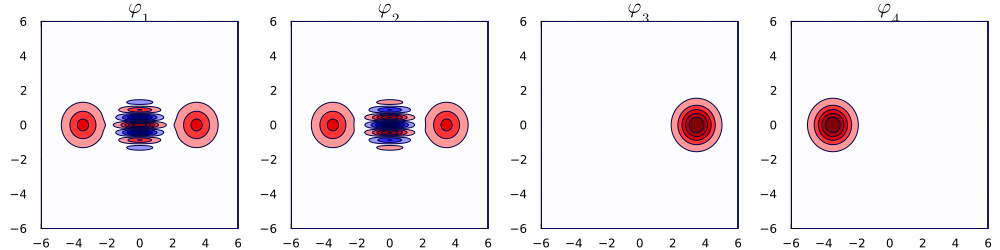

In [6]:
xx = range(-6, 6, length=200)
p1, p2, p3, p4 = plot_wigner.(φ, Ref(xx))

p = plot(p1, p2, p3, p4, layout=(1, 4), size=(1000, 1000/4), title=[L"$\varphi_1$" L"$\varphi_2$" L"$\varphi_3$" L"$\varphi_4$"],)
display(p)

In [7]:
tl = LinRange(0,2*T,100)
@time mesol = mesolve(H, ψplus, tl, c_ops; e_ops=[Jpp,], alg=Vern7());

  2.469621 seconds (5.80 M allocations: 387.268 MiB, 8.98% gc time, 89.25% compilation time)


In [8]:
opt = LRMesolveOptions( 
    alg        = Tsit5(),
    err_max    = 0,
    p0         = 0.,
    atol_inv   = 1e-6,
    compute_Si = true, 
    adj_condition="variational",
    Δt = 0.
);

@time lrsol = lr_mesolve(H, z, B, tl, c_ops; e_ops=(Jpp,), opt=opt);

Progress: 100%
  6.666022 seconds (32.36 M allocations: 2.037 GiB, 8.92% gc time, 96.67% compilation time)


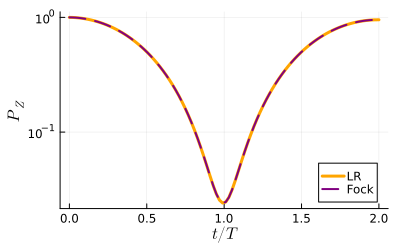

In [9]:
PZ_me = real(mesol.expect[1,:])
PZ_lr = real(lrsol.expvals[1,:])

p = plot(tl./T, PZ_lr, color=:orange, lw=3, label="LR", yaxis=:log, size=(400, 250))
plot!(tl./T, PZ_me, color=:purple, lw=2, ls=:dash, label="Fock")

xlabel!(L"t/T")
ylabel!(L"P_Z")
